# **D√©tection de la pneumonie - Application du Transfer Learning**

Dans ce notebook, nous nous attacherons √† entra√Æner un mod√®le capable de d√©tecter la pneumonie √† partir d'images scanner. Pour ce faire nous utiliserons le dataset **[Chest XRay Pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)** pour affiner un mod√®le Keras pr√©entrain√©. Nous suivrons ces √©tapes :  

### **1. Compr√©hension du probl√®me**  

La 1√®re √©tape est de comprendre notre probl√©matique. Cela nous permettra d'en tirer certaines conclusions, telles que le choix de la m√©trique √† laquelle nous accorderons le plus d'importance, ou la fa√ßon de r√©soudre les autres questions qui arriveront lors de la mise en oeuvre.  

### **2. Analyse du dataset**  

Nous devrons observer le dataset pour d√©terminer comment en standardiser le contenu afin de le rendre exploitable par le mod√®le.
Nous devrons √©galement pr√™ter attention √† la r√©partition des classes dans le dataset, afin de r√©√©quilibrer l'entra√Ænement si n√©cessaire.  

### **3. Preprocessing du dataset**

Nous adapterons notre dataset au format attendu par le mod√®le.

### **4. Cr√©ation du mod√®le**

Le mod√®le sera cr√©√© par une fonction selon les param√®tres d√©finis dans settings.

### **5. Entra√Ænement du mod√®le**

Nous entrainerons le mod√®le sur notre dataset d'entra√Ænement, et surveillerons ses r√©sultats √† chaque epoch pour v√©rifier qu'il √©volue dans le bon sens et ne se surentra√Æne pas.

### **6. Mise en place d'un suivi des tests**  

Gr√¢ce √† MLFlow, nous enregistrerons les r√©sultats de nos tests au fur et √† mesure (param√®tres et r√©sultats) afin de facilement comparer nos mod√®les/param√®tres d'entra√Ønement. Cela nous permetre de passer √† l'√©tape suivante :  

### **7. Choix du mod√®le**  

Apr√®s avoir test√© diff√©rents mod√®les pr√©entrain√©s potentiellement int√©ressants, nous les comparerons gr√¢ce aux m√©triques enregistr√©s dans MLFlow afin de choisir notre mod√®le de travail final.  

### **8. Affiner notre mod√®le**  

Une fois notre mod√®le final s√©lection√©, nous jouerons avec ses param√®tres afin de chercher les meilleures performances possibles pour le cas √©tudi√©.  

### **9. R√©sultats finaux**  

Nous pr√©senterons les r√©sultats finaux de notre mod√®le et le mettrons √† disposition pour d√©monstration.

## **0.a Importation des d√©pendances et des credentials de MLFlow**

In [1]:
import os
import shutil
import json

import kagglehub
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import mlflow
from mlflow.models.signature import infer_signature
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from dotenv import load_dotenv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from mlflow import MlflowClient

from functions.data.prepare_data import prepare_data
from functions.show_predictions import show_predictions
from functions.data.get_train_test import get_train_test
from functions.initialize_model import initialize_model
from functions.mlflow.get_run_name import get_run_name
from settings import params, model_name, folders, added_layers, experiment_name, testing_cycle
from functions.mlflow.show_parameters import show_parameters
from functions.data.dataset_analysis import dataset_analysis
from functions.mlflow.show_metrics import show_metrics
from functions.mlflow.show_matrix import show_matrix


# Loads the MLFlow credentials
load_dotenv()

2025-05-28 14:46:37.241347: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 14:46:37.257605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748436397.269503   24035 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748436397.272872   24035 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748436397.281656   24035 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

False

## **0.b Chargement du dataset**

Si le dataset n'est pas d√©j√† pr√©sent localement, on le r√©cup√®re automatiquement dans sa derni√®re version.

In [2]:
# Download latest version of dataset and store it locally
if not os.path.exists("data"):
    path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

    target_dir = "data"
    os.makedirs(target_dir, exist_ok=True)
    shutil.move(path, target_dir)
    removable_folder_paths = ("data/chest_xray/", "data/2/chest_xray/chest_xray", "data/2/chest_xray/__MACOSX")
    for folder_path in removable_folder_paths:
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            shutil.rmtree(folder_path)

## **1. Compr√©hension du probl√®me**

Nous sommes ici dans le cadre d'un **mod√®le √† application m√©dicale**. Nous devons donc √™tre tr√®s attentifs √† ce que nous faisons. Plusieurs possibilit√©s diff√©rentes peuvent influencer nos choix, selon l'usage de ce mod√®le :

- S'agit-il d'un mod√®le destin√© √† d√©tecter la possibilit√© d'une pneumonie **en amont de l'examen d'un professionnel de sant√© ?** Dans ce cas, nous voulons privil√©gier le recall, qui minimise les chances de passer √† c√¥t√© d'une pathologie, quitte a parfois donner de faux positifs.

- A l'inverse, s'il s'agit d'un mod√®le destin√© √† **valider le diagnostic positif d'un m√©decin**, on privil√©giera alors la pr√©cision, puisqu'il s'agira de d√©tecter la maladie √† coup s√ªr et d'√©viter les faux positifs.

Un mod√®le plus g√©n√©raliste pourrait privil√©gier l'accuracy, mais nous allons ici partir du principe que le mod√®le est destin√© √† d√©tecter la maladie **en amont** et d√©clencher l'appel √† l'expertise d'un m√©decin d√®s que le moindre doute est soulev√©. Nous privil√©gieront donc le recall, et en valeur secondaire la pr√©cision. On veut **un minimum de cas non d√©tect√©s** et une **qualit√© de diagnostic positif maximale**, car notre mod√®le a besoin d'√™tre fiable, de ne rater aucun cas mais √©galement d'√™tre **digne de confiance** (si on d√©tecte 100% des cas mais que la moiti√© des d√©tections sont des faux positifs, l'outil n'a aucune utilit√©).

## **2. Analyse du dataset**

Nous analysons le contenu du dataset, en particulier le format des images et la r√©partition des classes. Nous utiliserons la fonction **dataset_analysis** d√©finie dans **functions/dataset_analysis.py**

Nombre d'images en erreur : 0
Aper√ßu des diff√©rents formats d'image


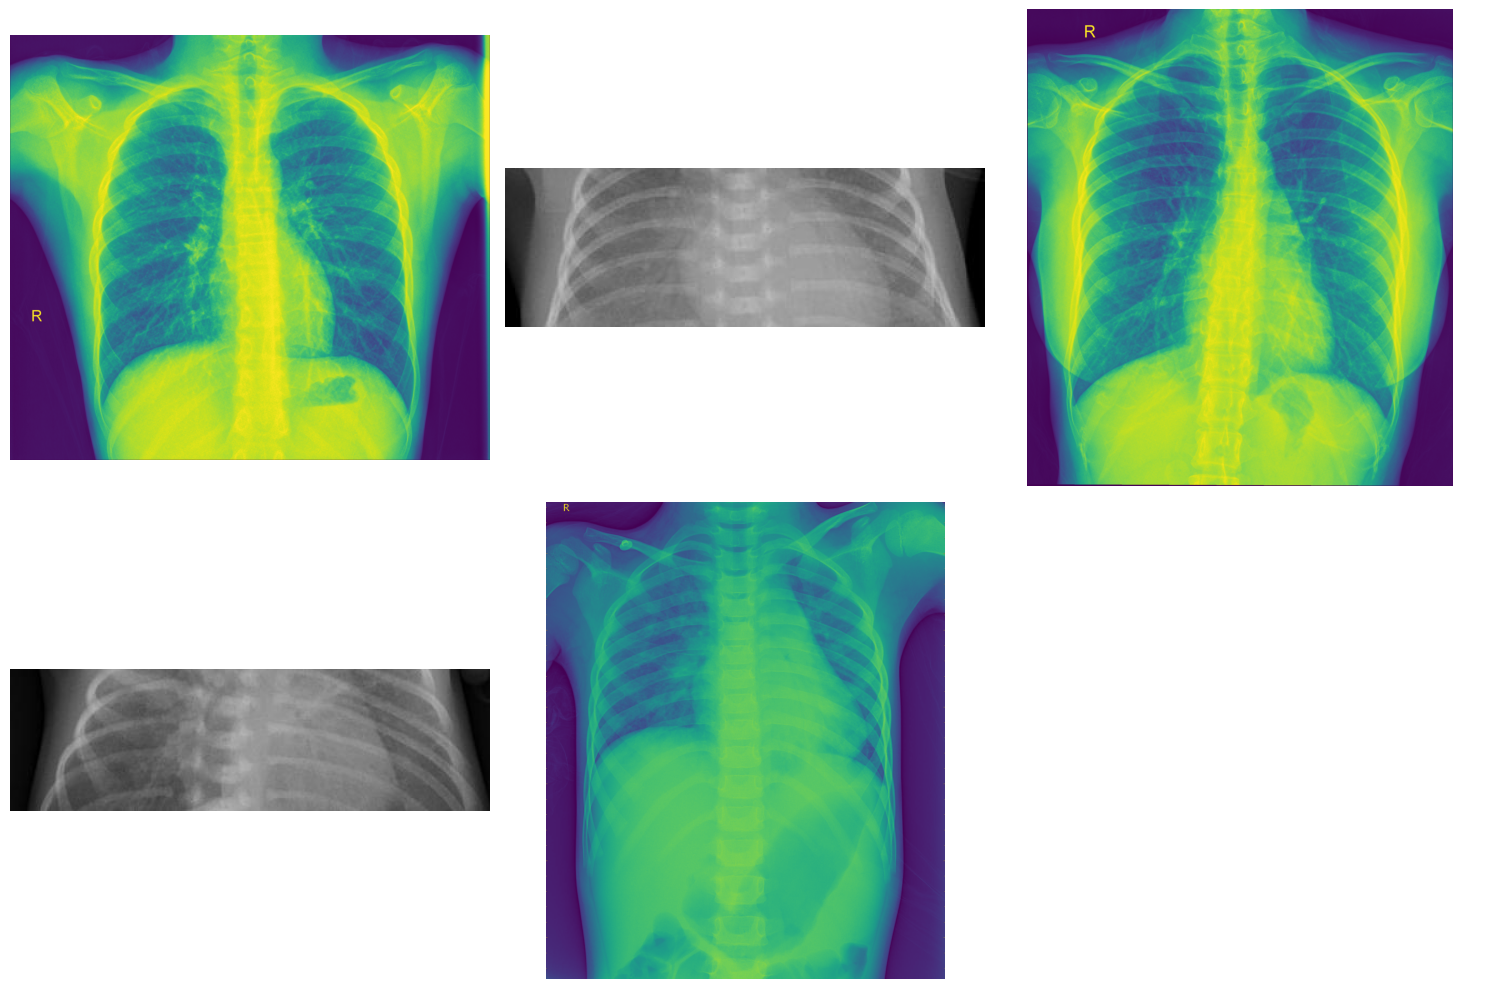

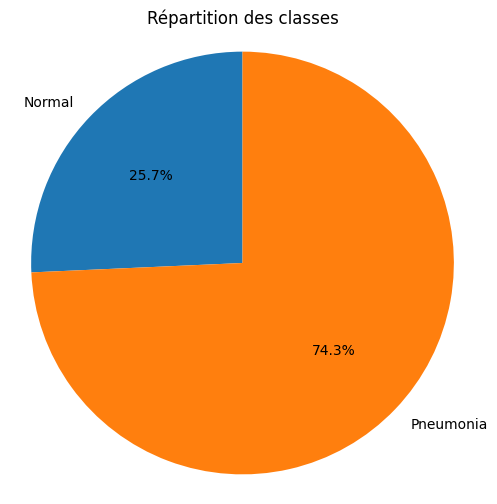

In [3]:
dataset_analysis()

On peut voir que les images du dataset peuvent prendre **diff√©rents ratio width/height**. Certaines sont en couleur, d'autres non mais cela ne devrait pas poser de souci car elles sont toujours monochrome. Une √©tude en niveaux de gris serait peut √™tre pr√©f√©rable. Comme les mod√®les pr√©entrain√©s attendent du rgb, on peut essayer de les tromper en triplant la valeur d'intensit√© du greyscale pour le faire passer pour du rgb. Cette approche devra √™tre test√©e pour en d√©finir l'efficacit√©. Le dataset ne contient pas d'images erron√©es. J'observe que les classes sont d√©s√©quilibr√©es avec **seulement un quart des images concernant des poumons sains**, il faudra en tenir compte lors de l'entra√Ænement et trouver des m√©thodes pour mitiger cela.

## **3. Preprocessing du dataset**

Selon les caract√©ristiques d√©finies dans **settings > params["img_size"]** et **params["rgb"]**, nous allons transformer les images du dataset pour qu'elles correspondent √† ces valeurs apr√®s avoir v√©rifi√© qu'elles n'y correspondent pas d√©j√† (gr√¢ce √† un fichier json **data_config**) et les enregistrer dans le dossier **data/processed**. Nous utiliserons pour cela la fonction **prepare_data** d√©finie dans **functions/img_treatment**. Cette fonction ajoutera des bandes noires sur les c√¥t√©s de l'image pour obtenir le ratio 1:1 d√©sir√© sans en alt√©rer le contenu, la redimensionnera et la convertira en faux rgb (intensit√© du pxiel dupliqu√© sur trois channels) si n√©cessaire.

In [4]:
config_path = os.path.join("data/processed", "data_config.json")

current_config = {
    "rgb": params["rgb"],
    "img_size": params["img_size"]
}

if os.path.exists(config_path):
    with open(config_path, "r") as f:
        previous_config = json.load(f)
    if previous_config != current_config:
        for folder in folders:
            prepare_data(folders[folder]["input"], folders[folder]["output"])
else:
    for folder in folders:
            prepare_data(folders[folder]["input"], folders[folder]["output"])

with open(config_path, "w") as f:
        json.dump(current_config, f)

Nous stockons ensuite les datasets d'entra√Ænement, de test et de validation via la fonction **get_train_test** d√©finie dans **functions/data**. 

Selon la valeur de settings > params["equilibrate"], nous **r√©√©quilibrerons les poids des classes** pour tenter de limiter l'influence du d√©s√©quilibre entre les classes lors de l'entra√Ænement.

In [5]:
# Pr√©paration des donn√©es de travail
X_train, y_train = get_train_test(folders["train"]["output"])
X_test, y_test = get_train_test(folders["test"]["output"])
X_val, y_val = get_train_test(folders["val"]["output"])

# R√©√©quilibrage du dataset
class_weight_dict = {0: 1.0, 1: 1.0}
if params["equilibrate"]:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))

On affiche un petit echantillonnage de nos dataset pour v√©rifier que tout est ok.

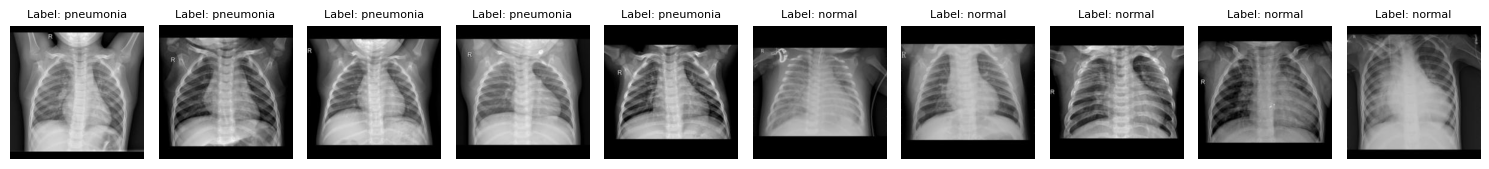

In [6]:
# Echantillonnage pour v√©rification
# S√©lectionner les indices des labels
indices_label_0 = [i for i, y in enumerate(y_train) if y == 0][:5]
indices_label_1 = [i for i, y in enumerate(y_train) if y == 1][:5]

# Fusionner les indices s√©lectionn√©s
selected_indices = indices_label_0 + indices_label_1

# Affichage
plt.figure(figsize=(15, 3))
for idx, i in enumerate(selected_indices):
    plt.subplot(1, 10, idx + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Label: {"normal" if y_train[i] else "pneumonia"}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

Nous transformons les images pour les rendre exploitables par les mod√®les (normalisation des valeurs de pixels, format des r√©ponses attendues..) 
 
Selon la valeur de settings > params["data_augmentation"], nous **appliquerons des modifications al√©atoires** (rotations, retournements, zoom..) aux images minoritaires pendant l'entrainement pour en aumenter artificellement la diversit√©.

In [7]:
# Preprocessing
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

#Transform y_train, y_test to the shape expected by the model
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

if params["data_augmentation"]:
    datagen = ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=True,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
    )

    datagen.fit(X_train)

## **4. Cr√©ation du mod√®le**

Nous cr√©ons le mod√®le gr√¢ce √† une fonction **initialize_model** qui prend en compte les param√®tres d√©finis dans **settings > params** et les couches suppl√©mentaires d√©finies dans **settings > added_layers**. Cel√† nous permet de **facilement tester de nombreux param√®tres/mod√®les diff√©rents sans devoir toucher au code**, et de **tout logger facilement dans MLFlow** par la suite pour comparaison ult√©rieure.

In [8]:
# Cr√©ation du mod√®le
model = initialize_model()
model.summary()

2025-05-28 14:46:47.962848: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ resnet50v2 (Functional)         ‚îÇ (None, 2048)           ‚îÇ    23,564,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 2048)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 128)            ‚îÇ       262,272 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 2)              ‚îÇ           258 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 23,827,330 (90.89 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

## **5. Entra√Ænement du mod√®le**

Nous entrainons le mod√®le sur notre dataset d'entra√Ænement, et surveillerons ses r√©sultats √† chaque epoch pour v√©rifier qu'il √©volue dans le bon sens et ne se surentra√Æne pas.

Pour ce cas pr√©cis nous surveillons son √©volution √† partir du dataset de test, car les m√©triques fournies par le dataset d'√©valuation sont trop √©loign√©es des r√©sultats finaux et ne nous offrent pas un bon indicateur de l'√©volution de la performance du mod√®le. En g√©n√©ral il aurait fallu ici utiliser le dataset de validation, plus l√©ger pour acc√©l√©rer l'entra√Ænement.

Si **settings > params["data_augmentation"] == True**, on utilise ici les techniques de rotation, zoom,.. d√©finies pr√©c√©demment.

In [9]:
# Entrainement du mod√®le
if params["data_augmentation"]:
    model_info = model.fit(
        datagen.flow(X_train, y_train, batch_size=params["batch_size"]),
        epochs=params["epochs"],
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict
    )
else:
    model_info = model.fit(
        X_train, y_train,
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict
    )

/media/charles-petit/Shared/Formation/Projets/2 - Transfer Learning/Transfer-Learning/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 163s 3s/step - accuracy: 0.7665 - auc: 0.8097 - loss: 2.0692 - mean_squared_error: 0.2099 - precision_normal: 0.5438 - precision_pneumonia: 0.9020 - recall_normal: 0.7704 - recall_pneumonia: 0.7651 - val_accuracy: 0.8606 - val_auc: 0.9313 - val_loss: 0.3411 - val_mean_squared_error: 0.1045 - val_precision_normal: 0.8155 - val_precision_pneumonia: 0.8875 - val_recall_normal: 0.8120 - val_recall_pneumonia: 0.8897


## **6. Mise en place d'un suivi des tests**  

Nous affichons la matrice de confusion de notre mod√®le, et l'enregistrons en tant qu'image pour pouvoir la logger plus tard.

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 871ms/step


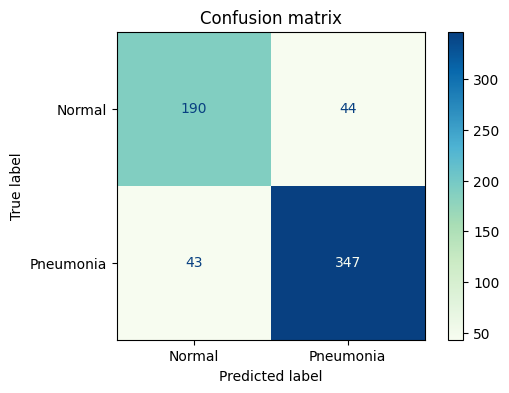

In [10]:
# Matrice de confusion
y_test_classes = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

labels = ["Normal", "Pneumonia"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

fig, ax = plt.subplots(figsize=(6,4))
disp.plot(cmap='GnBu', ax=ax) 
plt.title("Confusion matrix")
img_path = "confusion_matrix.png"
plt.savefig(img_path)
plt.show()
plt.close()

Gr√¢ce √† MLFlow, nous enregistrons les r√©sultats de nos tests (param√®tres et r√©sultats) afin de **facilement comparer nos mod√®les/param√®tres d'entra√Ønement**.

Nous loggons :
- Le lien du dataset
- Les param√®tres
- Les m√©triques finaux
- Les m√©triques de suivi durant l'entra√Ænement
- La matrice de confusion (sous forme d'artifact)
- Le mod√®le
- Les poids du mod√®le

In [11]:
# Log results into MLFlow
results = model.evaluate(X_test, y_test, return_dict=True)
mlflow.set_tracking_uri("http://localhost:5000")
experiment = mlflow.set_experiment(experiment_name=experiment_name)
run_name = get_run_name(experiment, params["model"])

weights_path = "model.weights.h5"
model.save_weights(weights_path)

with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id

    # Log dataset
    mlflow.log_param("dataset_url", "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")
    mlflow.set_tag("dataset", "chest-xray-pneumonia")
    mlflow.set_tag("testing_cycle", testing_cycle)

    # Log parameters
    mlflow.log_params(params)
    for i, added_layer in enumerate(added_layers):
        mlflow.log_params({
            f"added_layer_{i}": added_layer
        })
    # Log training metrics
    for epoch in range(len(model_info.history['loss'])):
        for metric_name, values in model_info.history.items():
            mlflow.log_metric(f"training {metric_name}", values[epoch], step=epoch)
    # Log final metrics
    mlflow.log_metrics(
        results
    )
    # Log confusion matrix
    mlflow.log_artifact(img_path, artifact_path="confusion_matrix")
    # Log model
    mlflow.log_artifact(weights_path)
    mlflow.tensorflow.log_model(
            model=model,
            artifact_path=model_name,
            input_example=X_test[:5],
            signature = infer_signature(X_test, model.predict(X_test))
        )

    model_uri = f"runs:/{run_id}/{model_name}"
    mlflow.register_model(model_uri=model_uri, name=model_name)

os.remove("model.weights.h5")
os.remove("confusion_matrix.png")

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 832ms/step - accuracy: 0.8268 - auc: 0.9116 - loss: 0.3918 - mean_squared_error: 0.1200 - precision_normal: 0.9232 - precision_pneumonia: 0.5048 - recall_normal: 0.8045 - recall_pneumonia: 0.5929


2025/05/28 14:50:08 INFO mlflow.tracking.fluent: Experiment with name 'no' does not exist. Creating a new experiment.


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 833ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 982ms/step


Registered model 'Transfer Learning - ResNet50V2' already exists. Creating a new version of this model...
2025/05/28 14:50:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Transfer Learning - ResNet50V2, version 9


üèÉ View run resnet50v2#1 at: http://localhost:5000/#/experiments/541642291336547672/runs/d4f03e874bde455c8b14861944672c47
üß™ View experiment at: http://localhost:5000/#/experiments/541642291336547672


Created version '9' of model 'Transfer Learning - ResNet50V2'.


## **7. Choix du mod√®le**  

Apr√®s avoir test√© diff√©rents mod√®les pr√©entrain√©s potentiellement int√©ressants, nous les comparons gr√¢ce aux m√©triques enregistr√©s dans MLFlow afin de choisir notre mod√®le de travail final. Comme vu auparavant, nous allons nous int√©resser √† recall_pneumonia, precision_pneumonia, avec en soutien la courbe auc qui repr√©sente la fiabilit√© g√©n√©rale de notre mod√®le.

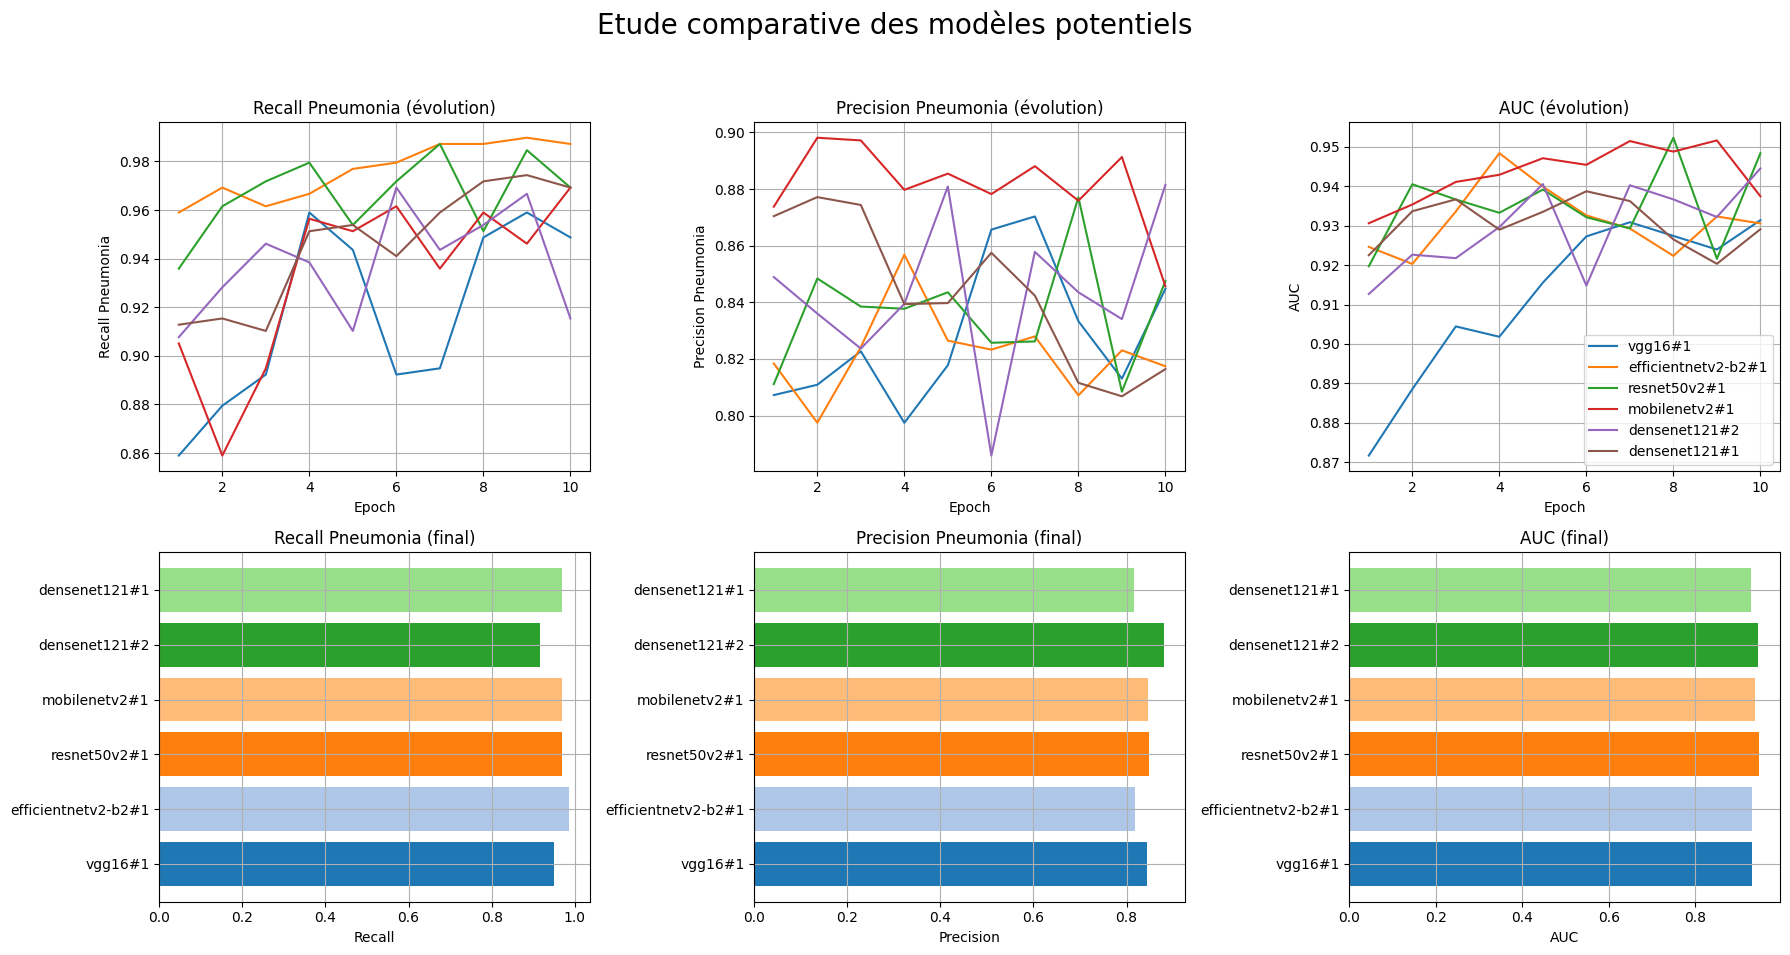

In [12]:
mlflow.set_tracking_uri("http://localhost:5000")

experiment_id = "348226835207806574"
client = MlflowClient()

# On r√©cup√®re les runs tagg√©s comme candidats pour les comparer
runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.candidate = 'true'",
    order_by=["metrics.step ASC"]
)

show_metrics(runs, client)

On affiche √©galement leurs **matrices de confusion** :

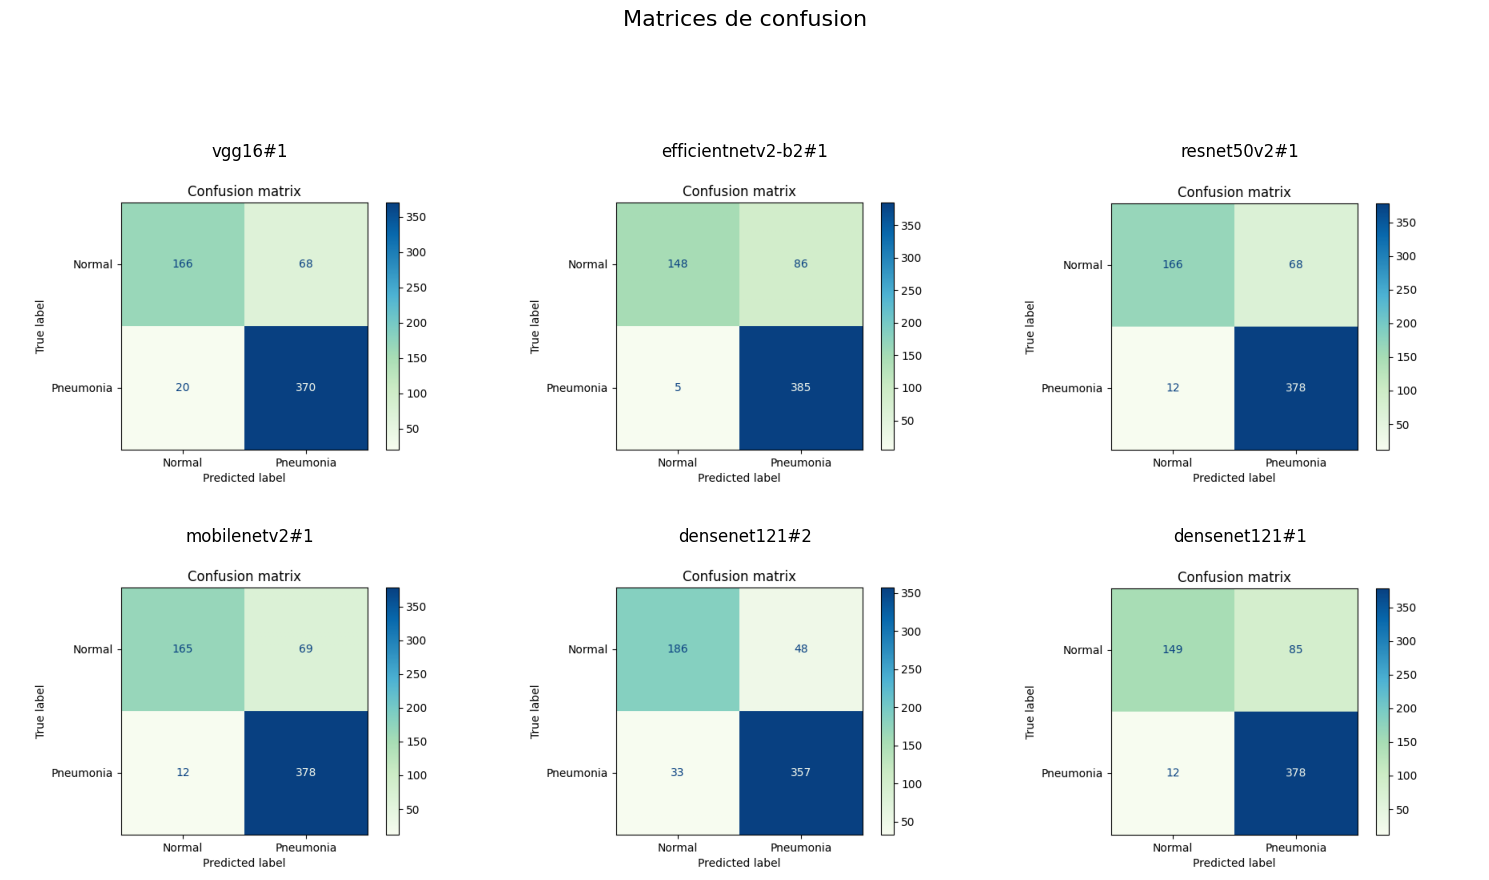

In [13]:
show_matrix(runs, client)

Apr√®s analyse de toutes ces m√©triques, nous choisirons de continuer avec le mod√®le **ResNet50V2**, qui combine **tr√®s bon recall**, **bonne pr√©cision** et **excellente fiabilit√©**. M√™me si il pr√©sente plus de faux positifs que DenseNet121 (+20), on consid√®re que c'est un prix acceptable popur d√©tecter d'avantages de cas positifs r√©els (+21).

## **8. Affiner notre mod√®le**  

Une fois notre mod√®le final s√©lection√©, nous jouons avec ses param√®tres afin de chercher les **meilleures performances possibles pour le cas √©tudi√©**. On changera les **couches de sortie**, on tentera de **d√©geler certaines couches du mod√®le pr√©entrain√©**, on modifiera la batch_size, le nombre d'epoch.. Pour voir quels param√®tres ont un effet positif sur ses performances. Tout cela sera logg√© dans MLFlow pour analyse comparative.

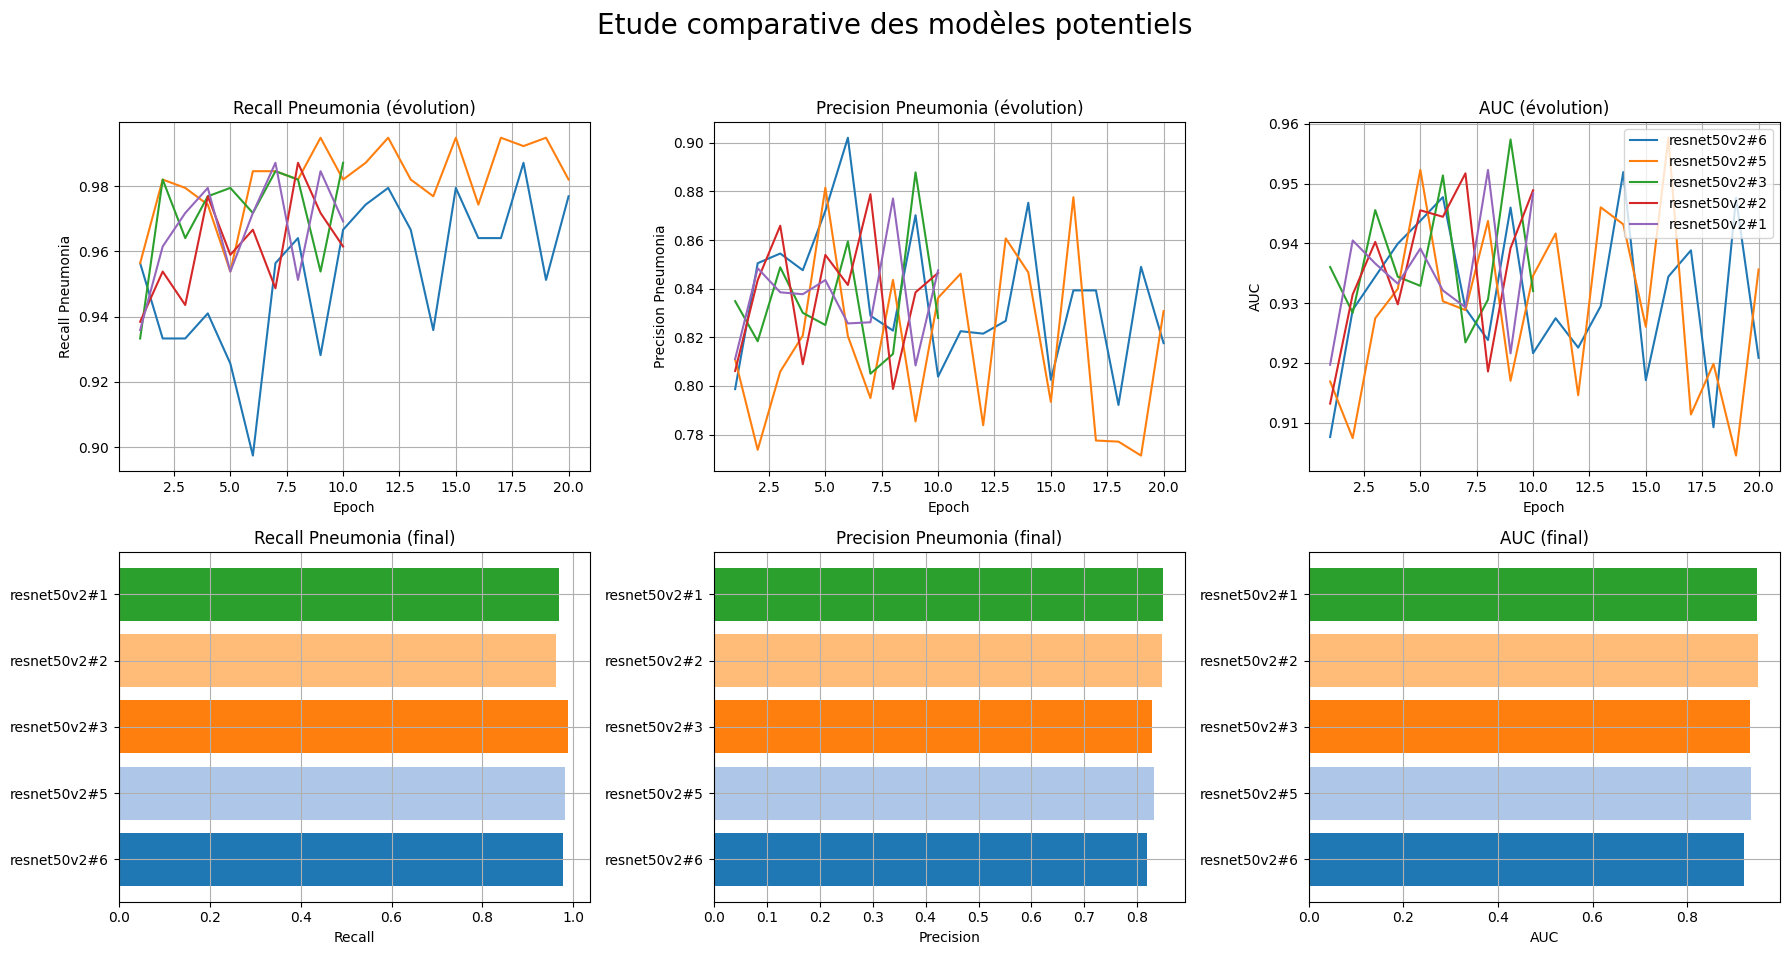

In [14]:
mlflow.set_tracking_uri("http://localhost:5000")

experiment_id = "348226835207806574"
client = MlflowClient()

# On r√©cup√®re les runs challenger pour les comparer
runs_1 = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.challenger = 'true'",
    order_by=["metrics.step ASC"]
)

# On r√©cup√®re le run champion
runs_2 = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.champion = 'true'",
    order_by=["metrics.step ASC"]
)

runs = runs_1 + runs_2

show_metrics(runs, client)

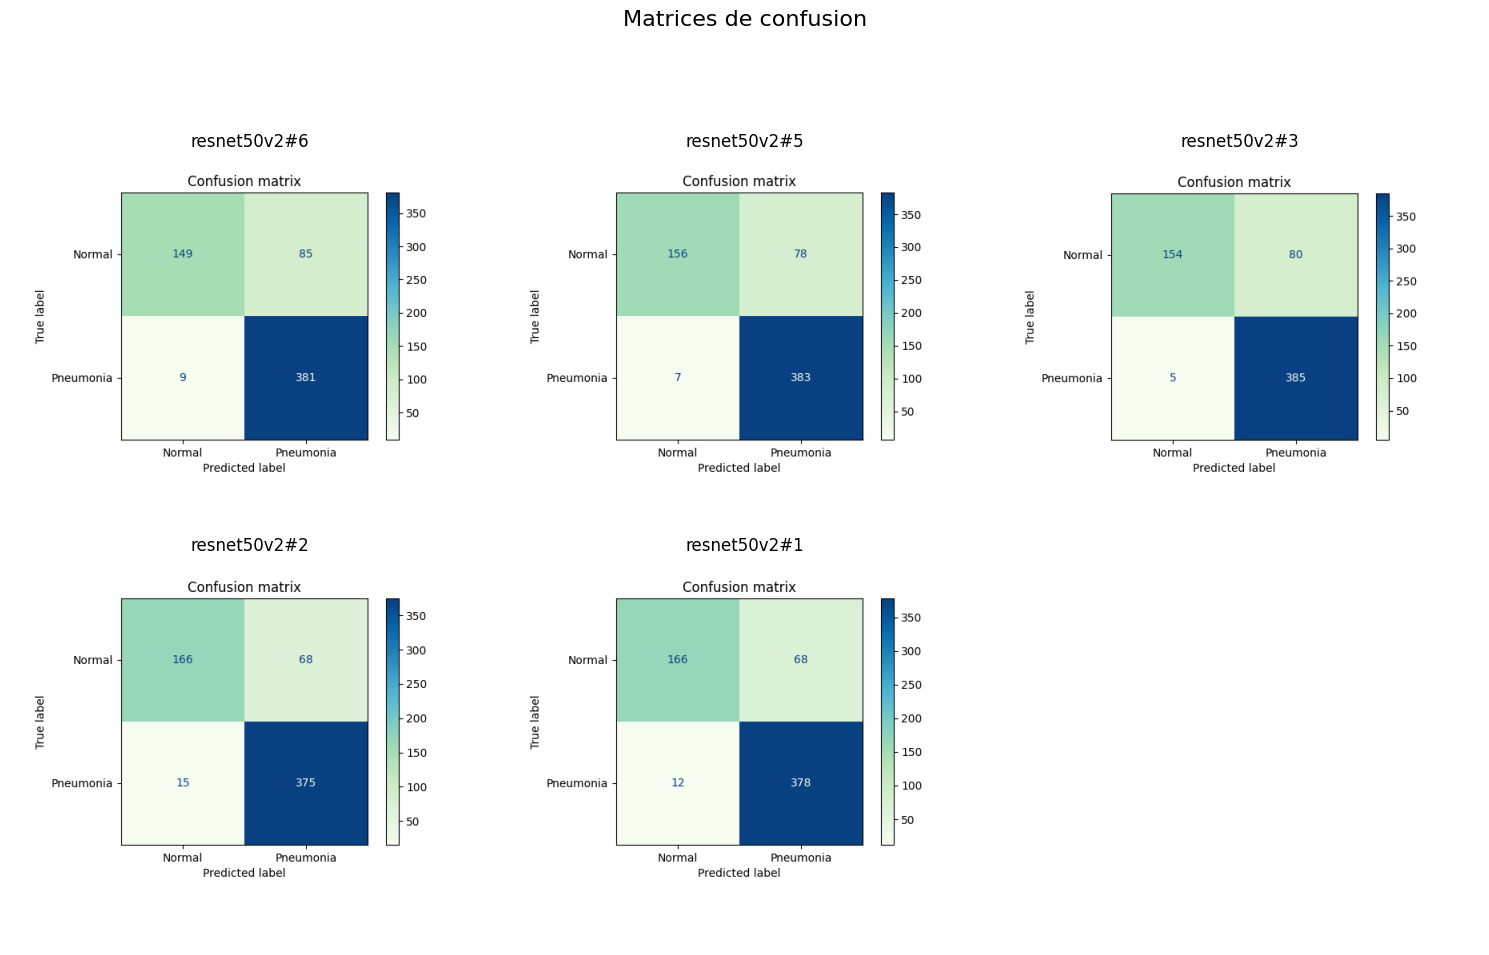

In [15]:
show_matrix(runs, client)

Affichons √©galement les param√®tres de ces runs

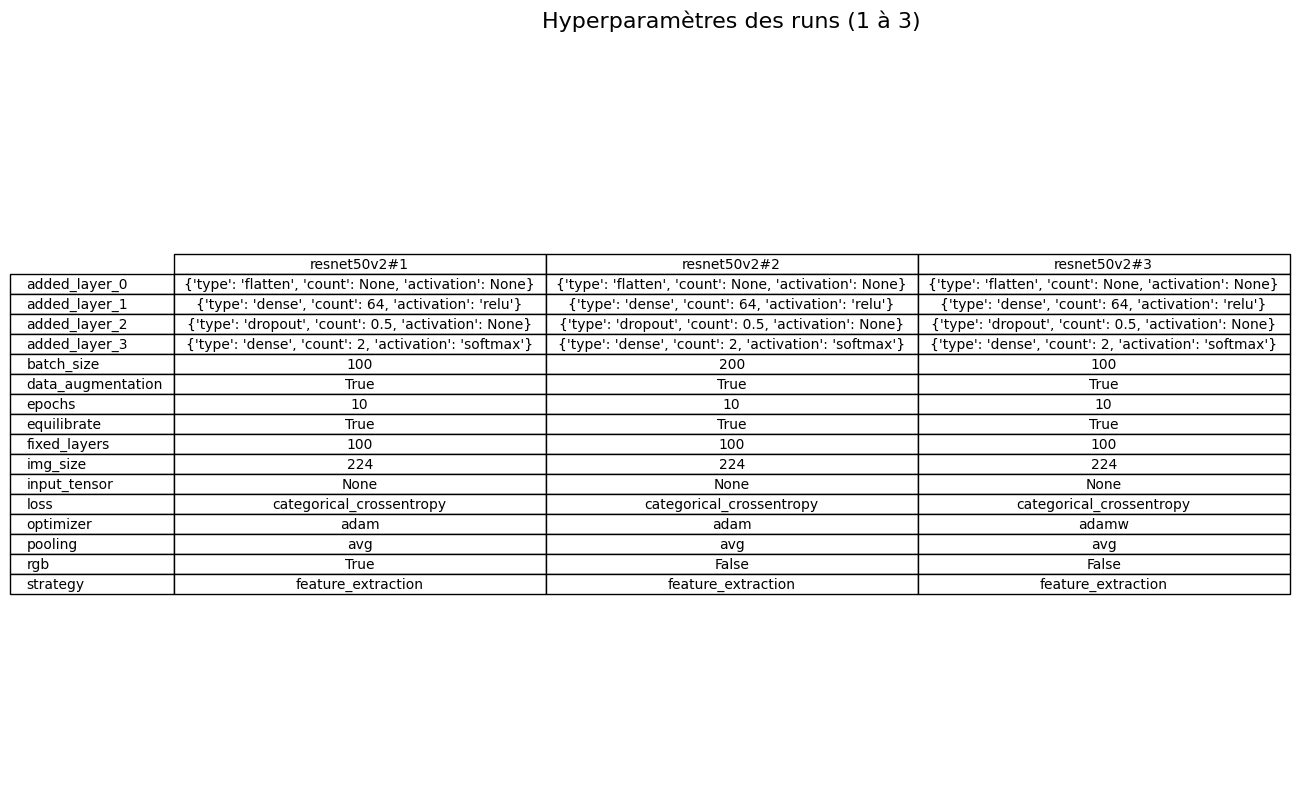

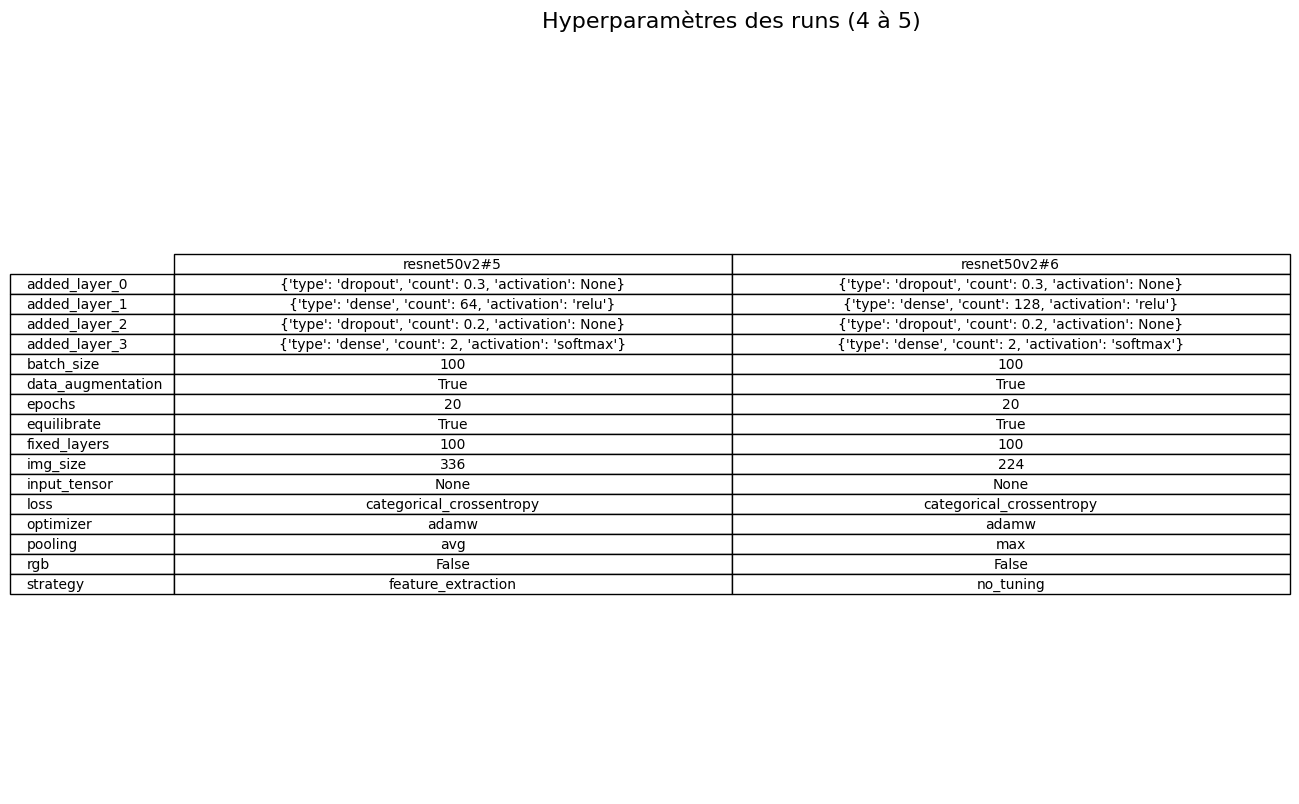

In [16]:
show_parameters(runs)

## **9. R√©sultats finaux**  

Apr√®s analyse de ces m√©triques, le mod√®le **ResNet50V2#1** reste le meilleur de par sa pr√©cision √©lev√©e. C'est donc ce mod√®le que nous allons proposer en d√©monstration :

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 870ms/step


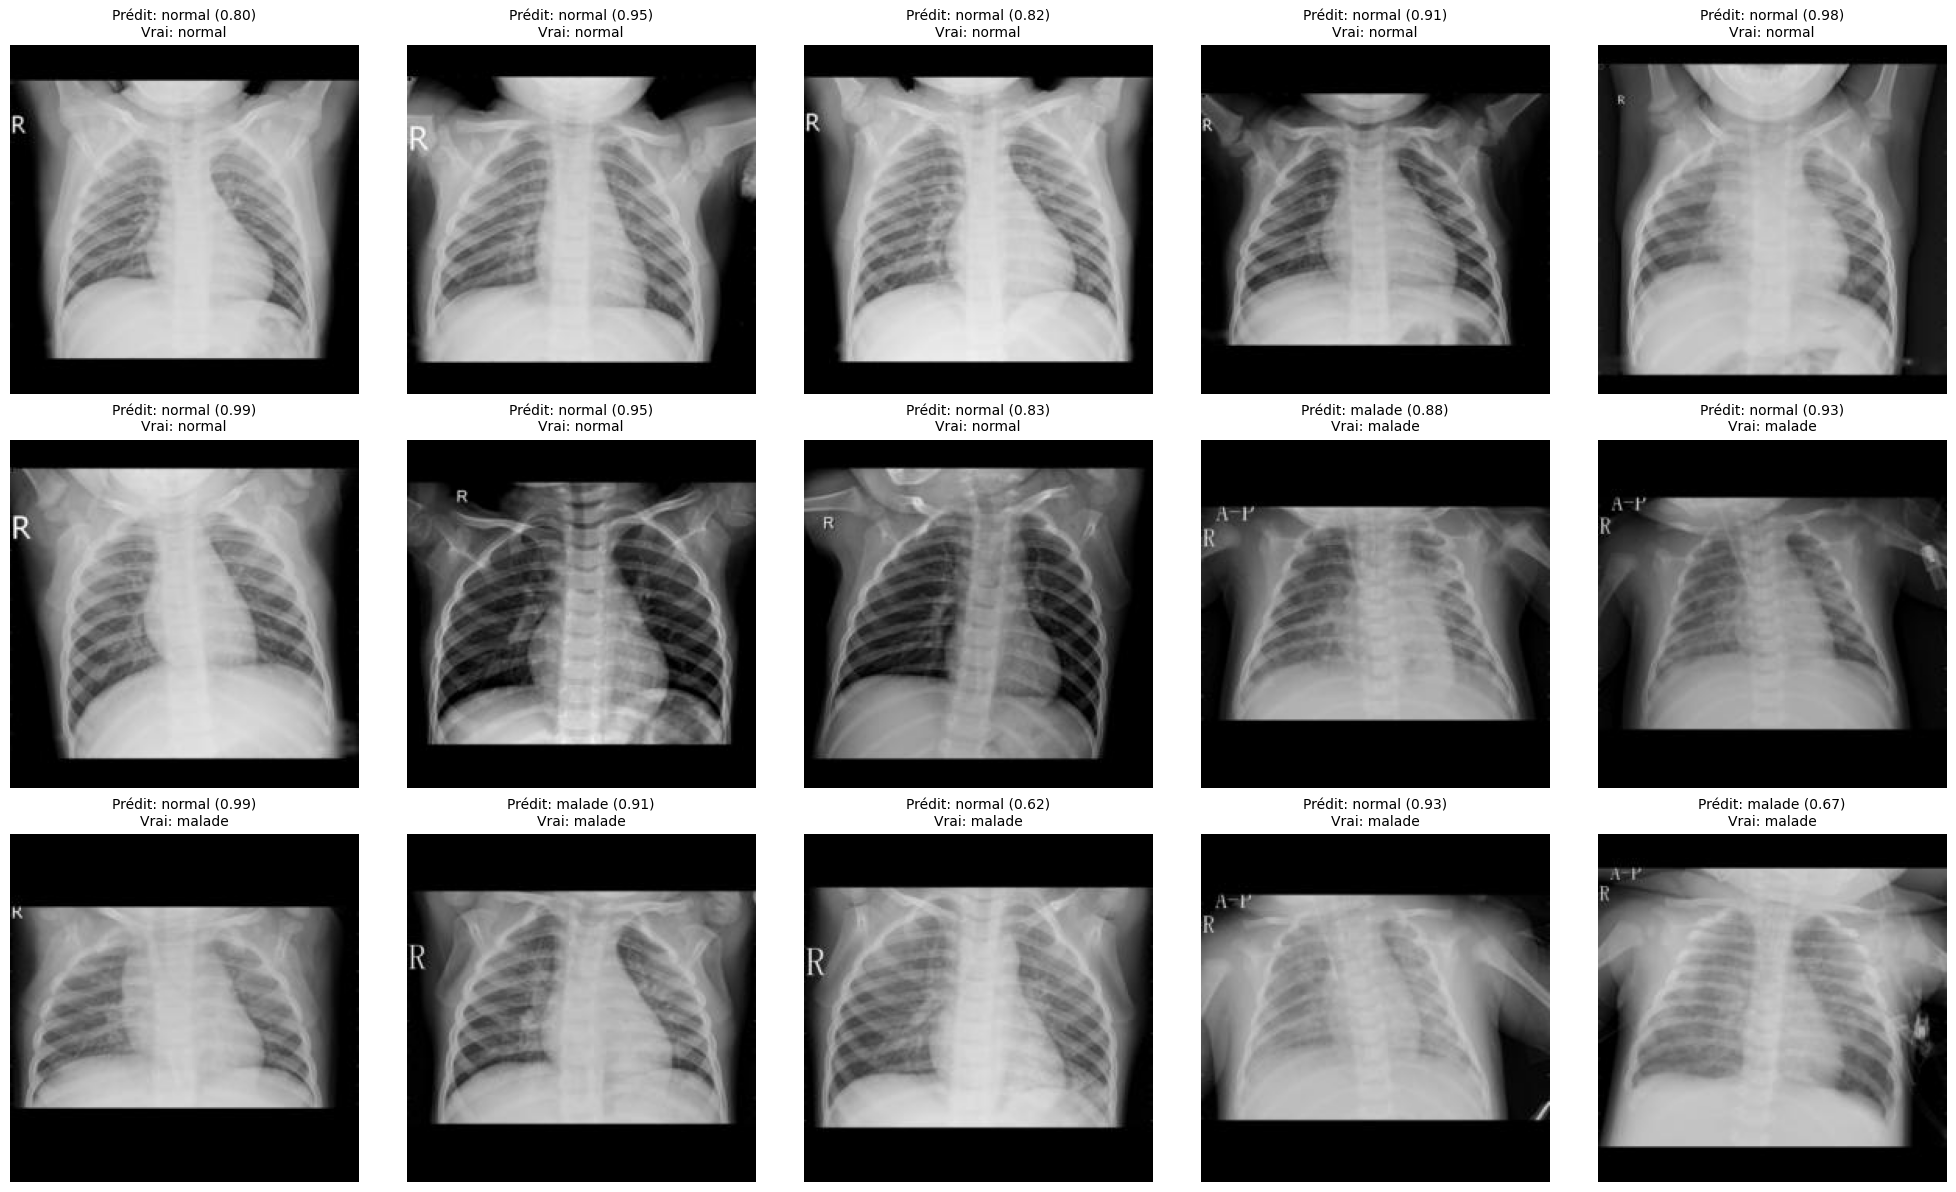

In [17]:
mlflow.set_tracking_uri("http://localhost:5000")

model_name = "Transfer Learning - ResNet50V2"
model_version = 1

model_uri = f"models:/{model_name}/{model_version}"

loaded_model = mlflow.tensorflow.load_model(model_uri)

y_pred = loaded_model.predict(X_test)
show_predictions(X_val, y_pred, y_true=y_val, class_names=["normal", "malade"], n_images=15)